<a href="https://colab.research.google.com/github/gaurav0886/Emotion-Detection-Audio/blob/main/Emotion_Detection_Audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Required Libraries**

In [20]:
!pip install librosa pandas numpy sklearn tensorflow keras matplotlib

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


**Load Required Libraries**

In [21]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D

**Download and Load Dataset**
** RAVDESS dataset**
**Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)**
Speech audio-only files (16bit, 48kHz .wav) from the RAVDESS. Full dataset of speech and song, audio and video (24.8 GB) available from Zenodo. Construction and perceptual validation of the RAVDESS is described in Open Access paper in PLoS ONE.

In [22]:
import zipfile
import requests

# Download the dataset
url = "https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip"
response = requests.get(url)
with open("audio_data.zip", "wb") as file:
    file.write(response.content)

# Unzip the dataset
with zipfile.ZipFile("audio_data.zip", "r") as zip_ref:
    zip_ref.extractall("audio_data")

**Resampy:-** Efficient sample rate conversion in Python. This package implements the band-limited sinc interpolation method for sampling rate conversion.

In [23]:
!pip install resampy

**Extract Features from Audio**
Define a function to extract Mel Frequency Cepstral Coefficients (MFCCs)
Mel-frequency cepstral coefficients (MFCCs) are a set of features that represent the spectral envelope of a sound signal. They are commonly used to analyze speech signals for tasks like speech recognition and speaker identification.

In [29]:
def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    return np.mean(mfccs.T, axis=0)

# Prepare dataset
dataset = []
labels = []
actor_folders = os.listdir("audio_data")

for actor in actor_folders:
    actor_path = os.path.join("audio_data", actor)
    if os.path.isdir(actor_path):
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                file_path = os.path.join(actor_path, file)
                dataset.append(extract_features(file_path))
                labels.append(int(file[7]) - 1)  # Extract emotion label

# Convert to DataFrame
df = pd.DataFrame(dataset)
df["label"] = labels
df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,label
0,-686.393005,63.113647,-4.459662,14.113541,-1.917575,-1.222726,-4.858023,-6.273964,-13.468405,-1.303237,...,2.683630,3.280505,4.919947,5.147307,3.604149,4.565490,1.484977,0.399266,-2.661604,0
1,-528.296570,48.711960,-20.242147,5.168832,-7.995379,-10.478757,-9.846070,-8.259405,-15.572114,5.322620,...,3.396124,3.632149,0.503641,0.280591,1.508735,1.820782,0.663883,1.922878,2.520137,3
2,-533.241333,44.107174,-21.891911,7.493435,-8.730058,-7.558406,-13.462798,-10.276385,-8.299785,3.026749,...,4.952285,2.751632,4.254063,3.398425,2.980493,2.320852,-0.531899,-0.529932,1.367892,7
3,-654.068420,44.267906,-2.024347,9.647208,-0.431909,3.816997,-4.005130,-8.992208,-8.282523,0.285733,...,8.302183,6.300032,7.532376,4.847605,0.959889,1.432846,1.872894,3.616942,3.413851,3
4,-547.877869,44.814846,-22.761240,7.151763,-5.003314,-7.425490,-9.640414,-9.380350,-13.170219,4.045521,...,1.452821,1.980973,2.616647,1.192903,0.124760,-0.103952,1.565933,0.369217,-1.078253,2


**Model Training**

In [46]:
X = df.iloc[:, :-1].values
y = df["label"].values

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Build Emotion Detection Model**

In [47]:
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(set(y)), activation='softmax')
])

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Reshape input data
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.1585 - loss: 4.0488 - val_accuracy: 0.2708 - val_loss: 1.9490
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2492 - loss: 1.9559 - val_accuracy: 0.3368 - val_loss: 1.8410
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2964 - loss: 1.8511 - val_accuracy: 0.2986 - val_loss: 1.8073
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3019 - loss: 1.8098 - val_accuracy: 0.3542 - val_loss: 1.7690
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3110 - loss: 1.7429 - val_accuracy: 0.3611 - val_loss: 1.6924
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3421 - loss: 1.7459 - val_accuracy: 0.3924 - val_loss: 1.6184
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3813 - loss: 1.6599 - val_accuracy: 0.3993 - val_loss: 1.6257
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4052 - loss: 1.5954 - val_accuracy: 0.3819 - val_loss: 1.5873
Ep

**Evaluate Model Performance**

In [48]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6252 - loss: 1.3370 
Test Accuracy: 61.11%


**Plot Training History**

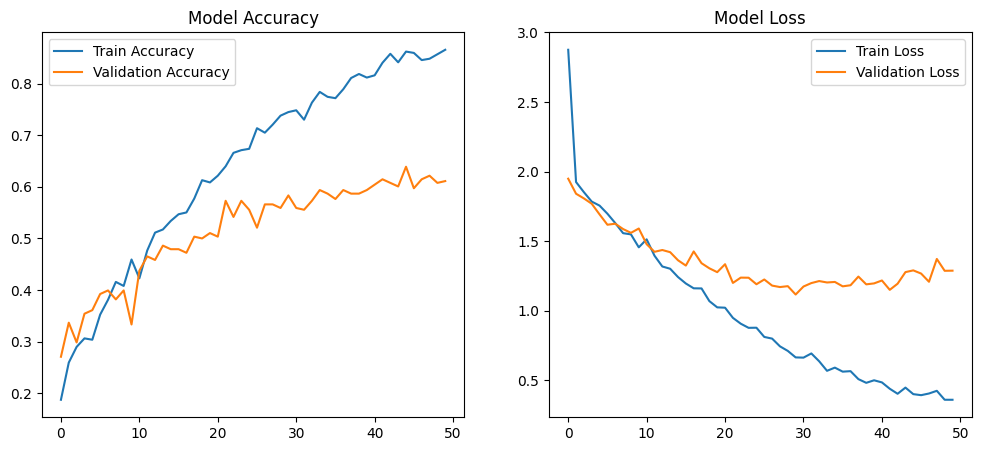

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.legend()
plt.title("Model Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.title("Model Loss")

plt.show()

**Save Model for Deployment in Keras**

In [50]:
model.save('Emotion_detection.keras')

In [52]:
!git clone https://github.com/gaurav0886/Emotion-Detection-Audio.git


Cloning into 'Emotion-Detection-Audio'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (4/4), done.


In [70]:
!cp /content/drive/MyDrive/Colab\ Notebooks/Emotion_Detection_Audio.ipynb /content/

In [71]:
!mv /content/Emotion_Detection_Audio.ipynb /content/Emotion-Detection-Audio/


In [72]:
%cd /content/Emotion-Detection-Audio
!git add Emotion_Detection_Audio.ipynb
!git commit -m "Added notebook for emotion detection"
!git push origin main

/content/Emotion-Detection-Audio
[main 78326ef] Added notebook for emotion detection
 1 file changed, 1 insertion(+)
 create mode 100644 Emotion_Detection_Audio.ipynb
fatal: could not read Username for 'https://github.com': No such device or address


In [65]:
!git config --global user.email "gaurav.vit08@gmail.com"


In [66]:
!git config --global user.name "Gaurav Sharma"

In [67]:
%cd /content/Emotion-Detection-Audio
!git add Emotion_Detection_Audio.ipynb
!git commit -m "Added notebook for emotion detection"
!git push origin main

/content/Emotion-Detection-Audio
fatal: pathspec 'Emotion_Detection_Audio.ipynb' did not match any files
On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	Emotion_detection.keras
	emotion_detection_model.h5

nothing added to commit but untracked files present (use "git add" to track)
fatal: could not read Username for 'https://github.com': No such device or address
